In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.datasets as datasets
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Excercise 1. PyTorch I

In [2]:
num_epochs = 5
batch_size = 100
learning_rate = 0.001

In [3]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};

In [4]:
train_dataset = datasets.FashionMNIST('fashion_data',
                        train=True,
                        transform=transforms.ToTensor(),
                        download=True)
test_dataset = datasets.FashionMNIST('fashion_data',
                        train=False,
                        transform=transforms.ToTensor(),
                        download=True)

In [5]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size, shuffle=True)

In [6]:
examples = enumerate(test_loader)
batch_idx, (images, labels) = next(examples)

In [7]:
images.shape

torch.Size([100, 1, 28, 28])

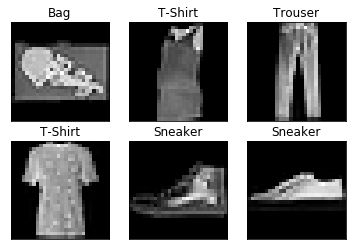

In [8]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i][0], cmap='gray')
    label = labels[i].item()
    plt.title(labels_map[label])
    plt.xticks([])
    plt.yticks([])

In [27]:
class CNN(nn.Module):
    def __init__(self, num_class):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            #depth=1, K=16, P=(5-1)/2, S=1, out=28x28x16 
            nn.Conv2d(1, 16, kernel_size=5, padding=2), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)) #14x14x16
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2), #14x14x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)) #7x7x32
        self.fc = nn.Linear(7*7*32, num_class)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [10]:
def train():
    model = CNN(len(labels_map))
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    ce_loss = nn.CrossEntropyLoss()
    
    losses = []
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = Variable(images.float())
            labels = Variable(labels)
            
            outputs = model(images)
            loss = ce_loss(outputs, labels)
            loss.backward()
            optimizer.step()
            
            if (i+1)%10 == 0:
                losses.append(loss.item());
            
            if (i+1)%100 == 0:
                print('Loss: ', np.around(loss.item(), 4), 'epoch: ', epoch, '/',num_epochs)
    return model, losses

In [12]:
model, losses = train()

Loss:  4.4766 epoch:  0 / 5
Loss:  2.8702 epoch:  0 / 5
Loss:  1.4357 epoch:  0 / 5
Loss:  1.6716 epoch:  0 / 5
Loss:  1.1181 epoch:  0 / 5
Loss:  0.8805 epoch:  0 / 5
Loss:  0.6385 epoch:  1 / 5
Loss:  1.0795 epoch:  1 / 5
Loss:  0.9323 epoch:  1 / 5
Loss:  0.8967 epoch:  1 / 5
Loss:  0.8009 epoch:  1 / 5
Loss:  0.8118 epoch:  1 / 5
Loss:  0.5843 epoch:  2 / 5
Loss:  0.74 epoch:  2 / 5
Loss:  0.6393 epoch:  2 / 5
Loss:  1.1501 epoch:  2 / 5
Loss:  1.0092 epoch:  2 / 5
Loss:  0.8373 epoch:  2 / 5
Loss:  0.94 epoch:  3 / 5
Loss:  0.9784 epoch:  3 / 5
Loss:  0.7678 epoch:  3 / 5
Loss:  1.1307 epoch:  3 / 5
Loss:  0.9352 epoch:  3 / 5
Loss:  1.0143 epoch:  3 / 5
Loss:  0.8228 epoch:  4 / 5
Loss:  0.7894 epoch:  4 / 5
Loss:  0.8423 epoch:  4 / 5
Loss:  0.9559 epoch:  4 / 5
Loss:  1.115 epoch:  4 / 5
Loss:  1.3567 epoch:  4 / 5


In [30]:
def test(model):
    model.eval()
    correct = 0
    total = 0
    for image, label in test_loader:
        image = Variable(image.float())
        output = model(image)
        predicted = torch.argmax(output, dim=1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        accuracy = 100 * correct / total        
    return accuracy

In [31]:
accuracy = test(model)
print('Accuracy: ', accuracy)

Accuracy:  66.66


Text(0.5,1,'Loss over training steps')

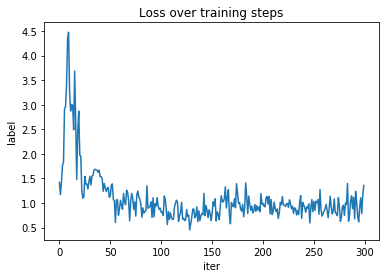

In [33]:
plt.plot(losses)
plt.xlabel('iter')
plt.ylabel('label')
plt.title('Loss over training steps')

## Excercise 2. PyTorch II

### (b)
Download a pretrained model from torchvision and use it as a feature extractor for CIFAR-10. This is called transfer learning. Try finetuning the pretrained model by unfreezing (parts of) the network. Note that you have to resize the data.

In [49]:
train_dataset_cif = datasets.CIFAR10('cifar10',
                        train=True,
                        transform=transforms.ToTensor(),
                        download=True)
test_dataset_cif = datasets.CIFAR10('cifar10',
                        train=False,
                        transform=transforms.ToTensor(),
                        download=True)

FileNotFoundError: [Errno 2] No such file or directory: 'cifar10/cifar-10-python.tar.gz'

In [46]:
train_loader_cif = DataLoader(dataset=train_dataset_cif, batch_size=batch_size, shuffle=True)
test_loader_cif = DataLoader(dataset=test_dataset_cif, batch_size=batch_size, shuffle=True)

In [47]:
examples_cif = enumerate(train_loader_cif)
batch_idx, (images_cif, labels_cif) = next(examples_cif)
images_cif.shape

torch.Size([100, 1, 28, 28])

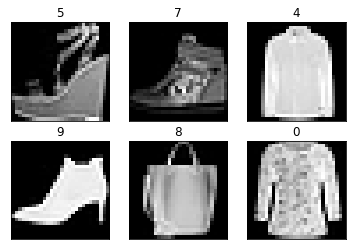

In [48]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images_cif[i][0], cmap='gray')
    plt.title(labels_cif[i].item())
    plt.xticks([])
    plt.yticks([])

In [ ]:
vgg16 = models.vgg16()